In [14]:
# Загружаем Билиотеки
import csv
import os
import pickle
import codecs
import random
import array

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
!pip install deap

In [16]:
from deap import base
from deap import creator
from deap import tools
from deap import tools
from deap import algorithms

In [17]:
# Подключаем Диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Файл с локациями 29 отправных точек
testLoc = '/content/drive/My Drive/datasets/tsp-data/bayg29-loc.pickle'
fn = open(testLoc, 'rb')
fn_loc = pickle.load(fn)
for i in fn_loc:
    print(i)

[1150. 1760.]
[ 630. 1660.]
[  40. 2090.]
[ 750. 1100.]
[ 750. 2030.]
[1030. 2070.]
[1650.  650.]
[1490. 1630.]
[ 790. 2260.]
[ 710. 1310.]
[840. 550.]
[1170. 2300.]
[ 970. 1340.]
[510. 700.]
[750. 900.]
[1280. 1200.]
[230. 590.]
[460. 860.]
[1040.  950.]
[ 590. 1390.]
[ 830. 1770.]
[490. 500.]
[1840. 1240.]
[1260. 1500.]
[1280.  790.]
[ 490. 2130.]
[1460. 1420.]
[1260. 1910.]
[ 360. 1980.]


In [19]:
# Матрица с раcчетами растояния между локациями
testDist ='/content/drive/My Drive/datasets/tsp-data/bayg29-dist.pickle'
fd = open(testDist, 'rb')
fd_dist = pickle.load(fd)
for i in fd_dist:
    print(i)

[0, 529.5281, 1158.0155, 771.7513, 482.59714, 332.4154, 1217.4153, 364.0055, 616.1169, 629.36475, 1249.0797, 540.37024, 456.94638, 1238.2245, 948.4725, 574.8913, 1488.3884, 1134.0635, 817.435, 671.193, 320.15622, 1422.3923, 864.0023, 282.3119, 978.67255, 756.63727, 460.10867, 186.01076, 820.061]
[529.5281, 0, 730.0685, 572.7128, 388.973, 572.8001, 1435.4442, 860.5231, 620.967, 359.02646, 1129.6902, 837.37683, 466.9047, 967.47095, 769.41534, 796.30396, 1142.3221, 817.8631, 819.87805, 272.94687, 228.25424, 1168.4177, 1280.8201, 650.0, 1086.0018, 490.408, 864.0023, 677.7905, 418.68842]
[1158.0155, 730.0685, 0, 1218.2775, 712.5307, 990.202, 2160.0232, 1521.2167, 769.0253, 1028.251, 1735.3962, 1149.3477, 1194.7385, 1467.3104, 1385.7128, 1526.3354, 1511.9855, 1299.7307, 1516.4432, 890.2247, 852.3497, 1652.4528, 1990.6029, 1355.1753, 1796.5522, 451.7743, 1570.1274, 1233.2072, 338.37848]
[771.7513, 572.7128, 1218.2775, 0, 930.0, 1009.6039, 1006.2306, 910.2197, 1160.6895, 213.77559, 557.315, 12

In [20]:
# Парсинг данных из файлов
# Создание класса тестового маршрута
class TestRoute:

  def __init__(self, name):
    # переменные
    self.name = name
    self.locations = []
    self.distances = []
    self.tspSize = 0
    self.__initData ()

  # Длина маршрута
  def __len__(self):
    return self.tspSize

  # Чтение данных из файлов
  def __initData(self):
    try:
      self.locations = pickle.load(open(testLoc, 'rb'))
      self.distances = pickle.load(open(testDist, 'rb'))
    except (OSError, IOError):
      pass

    self.tspSize = len(self.locations)

  # Расчет Общей дистанции 
  def getTotalDistance(self, indices):
    distance = self.distances[indices[-1]][indices[0]]
    for i in range(len(indices) - 1):
      distance += self.distances[indices[i]][indices[i + 1]]

    return distance
  # Визуализация данных
  def plotData(self, indices):
    plt.scatter(*zip(*self.locations), marker='*', color='red')
    locs = [self.locations[i] for i in indices]
    locs.append(locs[0])
    plt.plot(*zip(*locs), linestyle='-', color='black')

    return plt

In [21]:
# Класс используется как контейнер индексов городов вместе с их координатами и расстояниями друг от друга
class RoutingProblem:

    def __init__(self, tspName, numOfVehicles, depotIndex):
        self.tsp = TestRoute(tspName)
        self.numOfVehicles = numOfVehicles
        self.depotIndex = depotIndex

    def __len__(self):
        return len(self.tsp) + self.numOfVehicles - 1
    
    # разбивает заданный список на маршруты, обнаруживая разделители
    def getRoutes(self, indices):
        routes = []
        route = []
        for i in indices:
          if i == self.depotIndex:
            continue
          if not self.isSeparatorIndex(i):
            route.append(i)
          else:
            routes.append(route)
            route = []  
        if route or self.isSeparatorIndex(i):
            routes.append(route)
        return routes

    def isSeparatorIndex(self, index):
      return index >= len(self) - (self.numOfVehicles - 1)
    
    # вычисляет полную длину пути 
    def getRouteDistance(self, indices):
      if not indices:
        return 0
      distance = self.tsp.distances[self.depotIndex][indices[0]]
      distance += self.tsp.distances[indices[-1]][self.depotIndex]
      for i in range(len(indices) - 1):
        distance += self.tsp.distances[indices[i]][indices[i + 1]]
      return distance

    # вычисляет итоговую длину пути для маршрутов
    def getTotalDistance(self, indices):
      totalDistance = 0
      for route in self.getRoutes(indices):
        routeDistance = self.getRouteDistance(route)
        print(f" длина маршрута: {routeDistance}")
        totalDistance += routeDistance
      return totalDistance

    # вычисляет максимальную длину пути для маршрутов
    def getMaxDistance(self, indices):
      maxDistance = 0
      for route in self.getRoutes(indices):
        routeDistance = self.getRouteDistance(route)
        print(f" длина маршрута: {routeDistance}")
        maxDistance = max(routeDistance, maxDistance)
      return maxDistance

    # вычисляет среднию длину пути для маршрутов
    def getAvgDistance(self, indices):
      routes = self.getRoutes(indices)
      totalDistance = 0
      counter = 0
      for route in routes:
        if route:
          routeDistance = self.getRouteDistance(route)
          print(f" длина маршрута: {routeDistance}")
          totalDistance += routeDistance
          counter += 1
      return totalDistance/counter

    # разбивает список индексов на отдельные маршруты и рисует каждый маршрут своим цветом
    def plotData(self, indices):
      plt.scatter(*zip(*self.tsp.locations), marker='.', color='red')
      d = self.tsp.locations[self.depotIndex]
      plt.plot(d[0], d[1], marker='x', markersize=10, color='green')
      routes = self.getRoutes(indices)
      color = iter(plt.cm.rainbow(np.linspace(0, 1, self.numOfVehicles)))
      for route in routes:
        route = [self.depotIndex] + route + [self.depotIndex]
        stops = [self.tsp.locations[i] for i in route]
        plt.plot(*zip(*stops), linestyle='-', color=next(color))

      return plt


маршрут целиком: [20, 3, 0, 23, 8, 7, 25, 4, 29, 21, 17, 2, 18, 13, 1, 28, 16, 22, 30, 26, 9, 15, 11, 12, 5, 6, 27, 24, 10, 14, 19]
маршруты: [[20, 3, 0, 23, 8, 7, 25, 4], [21, 17, 2, 18, 13, 1, 28, 16, 22], [26, 9, 15, 11, 5, 6, 27, 24, 10, 14, 19]]
 длина маршрута: 6137.20654296875
 длина маршрута: 10125.1103515625
 длина маршрута: 8959.701171875
максимальная длина маршрута = 10125.1103515625


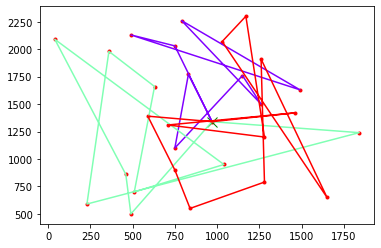

In [22]:
def main():
    vrp = RoutingProblem("Маршрут из 3 транспортных средств: ", 3, 12)
    randomSolution = random.sample(range(len(vrp)), len(vrp))
    print(f"маршрут целиком: {randomSolution}")
    print(f"маршруты: {vrp.getRoutes(randomSolution)}")
    print(f"максимальная длина маршрута = {vrp.getMaxDistance(randomSolution)}")
    plot = vrp.plotData(randomSolution)
    plot.show()

main()

In [23]:
!pip install deap

In [24]:
# Модификация алгоритма 
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """Этот алгоритм аналогичен алгоритму DEAP eaSimple (), с той модификацией, что
    halloffame используется для реализации механизма элитарности. Особи, содержащиеся в halloffame, 
    непосредственно вводятся в следующее поколение и не подвергаются
    генетическим операторам отбора, скрещивания и мутации."""
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")
    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0
    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)
    for gen in range(1, ngen + 1):
        offspring = toolbox.select(population, len(population) - hof_size)
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        offspring.extend(halloffame.items)
        halloffame.update(offspring)
        population[:] = offspring
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


In [25]:
# Фиксированное начальное значение генератора случайных чисел
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

TSP_NAME = "Маршрут для 3 транспортных средств"
NUM_OF_VEHICLES = 3
DEPOT_LOCATION = 12
vrp = RoutingProblem(TSP_NAME, NUM_OF_VEHICLES, DEPOT_LOCATION)

# Константы генетического алгоритма
POPULATION_SIZE = 500 # количество индивидуумов в популяции
P_CROSSOVER = 0.9  # вероятность скрещивания
P_MUTATION = 0.2   # вероятность мутации индивидуума
MAX_GENERATIONS = 1000 # максимальное количество поколений
HALL_OF_FAME_SIZE = 30 # константы задачи

toolbox = base.Toolbox() # класс Toolbox, который позволяет регистрировать новые функции
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # класс Fitness,задача – минимизировать, то выбираем стратегию FitnessMin
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin) # для представления индивидуумов используется класс с  именем Individual
toolbox.register("randomOrder", random.sample, range(len(vrp)), len(vrp)) # оператор randomOrder В результате генерируется случайный список индексов от 0 до n – 1
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder) # оператор IndividualCreator. Он вызывает оператор randomOrder и обходит созданный им список с целью создать хромосому
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator) # оператор populationCreator, который порождает список индивидуумов, вызывая в цикле оператор IndividualCreator
# Реализовав хромосому, мы можем определить функцию вычисления приспособленности. 
# tspDistance(), которая вызывает метод getTotalDistance()
def vrpDistance(individual):
    return vrp.getMaxDistance(individual),

# определение генетических операторов.
# будеми спользовать турнирный отбор с турниром размера 2
toolbox.register("evaluate", vrpDistance)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(vrp))
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=2.0/len(vrp))


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Streaming output truncated to the last 5000 lines.
 длина маршрута: 9648.0703125
 длина маршрута: 0
 длина маршрута: 4606.5166015625
 длина маршрута: 4573.818359375
 длина маршрута: 4516.02294921875
 длина маршрута: 7034.93994140625
 длина маршрута: 5073.54296875
 длина маршрута: 5175.763671875
 длина маршрута: 4606.5166015625
 длина маршрута: 4573.818359375
 длина маршрута: 4516.02294921875
 длина маршрута: 4606.5166015625
 длина маршрута: 4573.818359375
 длина маршрута: 4570.77978515625
 длина маршрута: 5297.9990234375
 длина маршрута: 4577.51708984375
 длина маршрута: 4570.77978515625
 длина маршрута: 5183.6650390625
 длина маршрута: 4432.6767578125
 длина маршрута: 4570.77978515625
 длина маршрута: 4606.5166015625
 длина маршрута: 4573.818359375
 длина маршрута: 4516.02294921875
 длина маршрута: 4606.5166015625
 длина маршрута: 4577.51708984375
 длина маршрута: 4516.02294921875
 длина маршрута: 4606.5166015625
 длина маршрута: 4573.818359375
 длина маршрута: 4516.02294921875
 длина

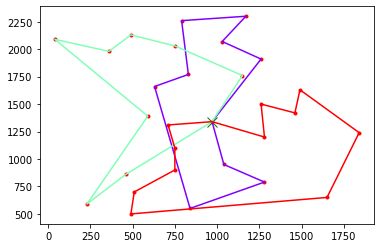

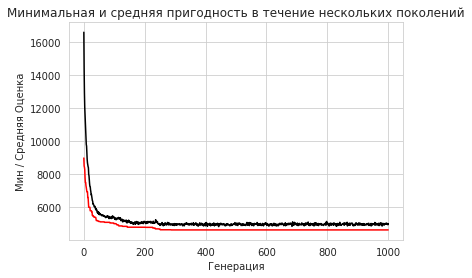

In [28]:
def main():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)
    best = hof.items[0]
    print(f"Лучший Вид Индивид: {best}")
    print(f"Лучший Фитнес: {best.fitness.values[0]}")

    print(f"маршрут целиком: {vrp.getRoutes(best)}")
    print(f"маршруты: {vrp.getRoutes(best)}")
    print(f"максимальная длина маршрута = {vrp.getMaxDistance(best)}")

    # plot best solution:
    plt.figure(1)
    vrp.plotData(best)

    # plot statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='black')
    plt.xlabel('Генерация')
    plt.ylabel('Мин / Средняя Оценка')
    plt.title('Минимальная и средняя пригодность в течение нескольких поколений')

    plt.show()



main()

In [29]:
# Фиксированное начальное значение генератора случайных чисел
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

TSP_NAME = "Маршрут для 6 транспортных средств"
NUM_OF_VEHICLES = 6
DEPOT_LOCATION = 12
vrp = RoutingProblem(TSP_NAME, NUM_OF_VEHICLES, DEPOT_LOCATION)

# Константы генетического алгоритма
POPULATION_SIZE = 500 # количество индивидуумов в популяции
P_CROSSOVER = 0.9  # вероятность скрещивания
P_MUTATION = 0.2   # вероятность мутации индивидуума
MAX_GENERATIONS = 1000 # максимальное количество поколений
HALL_OF_FAME_SIZE = 30 # константы задачи

toolbox = base.Toolbox() # класс Toolbox, который позволяет регистрировать новые функции
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # класс Fitness,задача – минимизировать, то выбираем стратегию FitnessMin
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMin) # для представления индивидуумов используется класс с  именем Individual
toolbox.register("randomOrder", random.sample, range(len(vrp)), len(vrp)) # оператор randomOrder В результате генерируется случайный список индексов от 0 до n – 1
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder) # оператор IndividualCreator. Он вызывает оператор randomOrder и обходит созданный им список с целью создать хромосому
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator) # оператор populationCreator, который порождает список индивидуумов, вызывая в цикле оператор IndividualCreator
# Реализовав хромосому, мы можем определить функцию вычисления приспособленности. 
# tspDistance(), которая вызывает метод getTotalDistance()
def vrpDistance(individual):
    return vrp.getMaxDistance(individual),

# определение генетических операторов.
# будеми спользовать турнирный отбор с турниром размера 2
toolbox.register("evaluate", vrpDistance)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(vrp))
toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=2.0/len(vrp))

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Streaming output truncated to the last 5000 lines.
 длина маршрута: 2341.25732421875
 длина маршрута: 2572.81982421875
 длина маршрута: 2819.54541015625
 длина маршрута: 2803.584716796875
 длина маршрута: 2693.381591796875
 длина маршрута: 2776.5146484375
 длина маршрута: 2341.25732421875
 длина маршрута: 2572.81982421875
 длина маршрута: 2819.54541015625
 длина маршрута: 2803.584716796875
 длина маршрута: 2693.381591796875
 длина маршрута: 2776.5146484375
 длина маршрута: 2669.597412109375
 длина маршрута: 2572.81982421875
 длина маршрута: 2819.54541015625
 длина маршрута: 2803.584716796875
 длина маршрута: 2693.381591796875
 длина маршрута: 2776.5146484375
 длина маршрута: 2341.25732421875
 длина маршрута: 2558.990234375
 длина маршрута: 2819.54541015625
 длина маршрута: 2770.065673828125
 длина маршрута: 2693.381591796875
 длина маршрута: 2549.637939453125
 длина маршрута: 2341.25732421875
 длина маршрута: 2572.81982421875
 длина маршрута: 2819.54541015625
 длина маршрута: 2177.8139

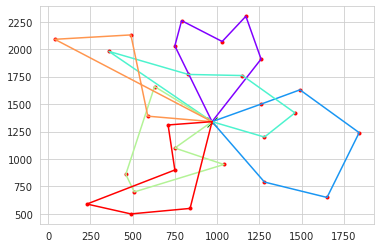

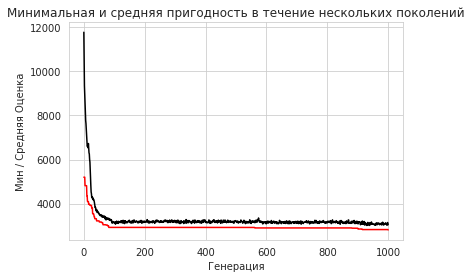

In [30]:
def main():
    population = toolbox.populationCreator(n=POPULATION_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
    population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)
    best = hof.items[0]
    print(f"Лучший Вид Индивид: {best}")
    print(f"Лучший Фитнес: {best.fitness.values[0]}")

    print(f"маршрут целиком: {best}")
    print(f"маршруты: {vrp.getRoutes(best)}")
    print(f"максимальная длина маршрута = {vrp.getMaxDistance(best)}")

    # plot best solution:
    plt.figure(1)
    vrp.plotData(best)

    # plot statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")
    plt.figure(2)
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='black')
    plt.xlabel('Генерация')
    plt.ylabel('Мин / Средняя Оценка')
    plt.title('Минимальная и средняя пригодность в течение нескольких поколений')
    
    plt.show()



main()